In [1]:
%load_ext lab_black
import pandas as pd
import numpy as np
import drnb as nb

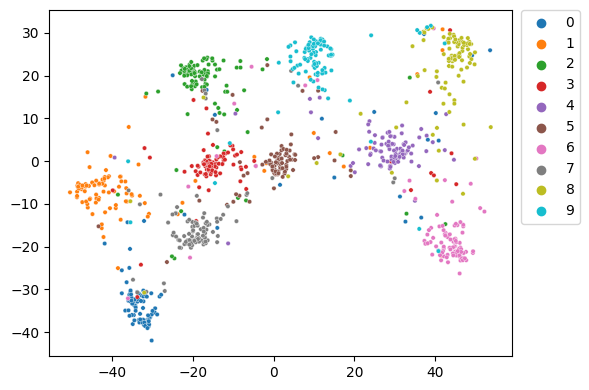

In [3]:
s1k_trimap = nb.embed_data("s1k", method="trimap")